# Projecto Machine Learning

In [102]:
import matplotlib.pyplot as plt
import matplotlib; matplotlib.rcParams['figure.figsize'] = (15, 6)
import numpy as np
import GPy
from OX_database import DissolvedOxygenDatabase
from IPython.display import display
from matplotlib import gridspec
#GPy.plotting.change_plotting_library('plotly')

# Cargar base de datos

In [8]:
path = "/home/rodrigo/ml_prob/DissolvedOxygenPrediction/database/"
sequence_size = 3
train_prop = 0.75
first_day = [2007, 7, 1]

database = DissolvedOxygenDatabase(database_path=path,
                                   sequence_size=3,
                                   train_prop=train_prop,
                                   sequence_batch_size=50,
                                   start_date=first_day)

def plot_mean_std(x, mean, std, real):
    fig = plt.figure()
    print(x.shape)
    print(mean.shape)
    print(std.shape)
    plt.plot(x, mean, "b", label = "Mean")
    mean = np.reshape(mean, (mean.shape[0],))
    x = np.reshape(x, (x.shape[0],))
    std = np.reshape(std, (std.shape[0],))
    real = np.reshape(real, (std.shape[0],))
    plt.fill_between(x, mean+2*std, mean-2*std, alpha = 0.3)
    plt.plot(x, real, 'x')
    plt.show()

loading Dissolved_Oxygen
loading Temperature
loading pH
loading Electrical_Conductivity
loading River_Discharge


In [9]:
train_input, train_target, train_days = database.next_batch(batch_size="all")
train_target = train_target[..., np.newaxis]
max_days = float(np.amax(train_days))
train_days = train_days[..., np.newaxis]/max_days
test_input, test_target, test_days = database.next_batch(set="test")
test_target = test_target[..., np.newaxis]
test_days = test_days[..., np.newaxis]/max_days
print(train_target.shape, train_days.shape)

((1661, 1), (1661, 1))


## Relación entre variables

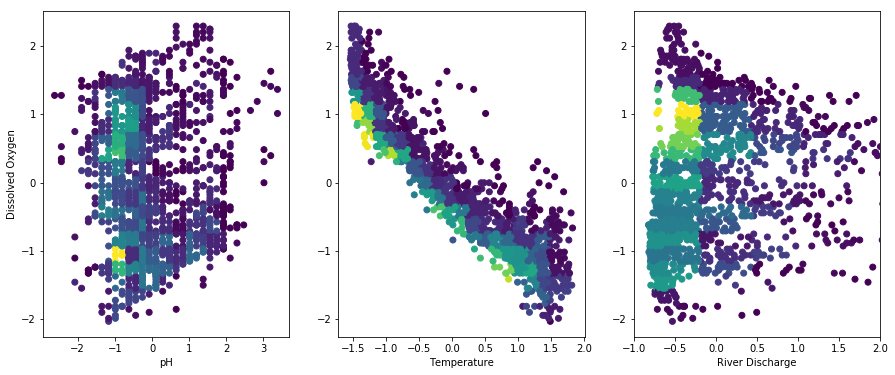

In [87]:
t_target = train_target[:, 0]
n_points = 20

f, axarr = plt.subplots(1,3)
xedges, yedges = np.linspace(np.amin(train_input[:, 0]), np.amax(train_input[:, 0]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 0], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 0], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[0].scatter(train_input[:, 0], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[0].set_xlabel("pH")
axarr[0].set_ylabel("Dissolved Oxygen")

xedges, yedges = np.linspace(np.amin(train_input[:, 1]), np.amax(train_input[:, 1]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 1], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 1], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[1].scatter(train_input[:, 1], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[1].set_xlabel("Temperature")

xedges, yedges = np.linspace(np.amin(train_input[:, 2]), np.amax(train_input[:, 2]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 2], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 2], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[2].scatter(train_input[:, 2], t_target, c=c)
axarr[2].set_xlim([-1, 2])
#axarr[2].set_xscale("sinh")
#plt.colorbar(sc, orientation='horizontal')
axarr[2].set_xlabel("River Discharge")
plt.show()

# All features forecasting

## Dissolver Oxygen

In [24]:
periodic_kernel1 = GPy.kern.PeriodicExponential(input_dim=1, period=0.3)

In [25]:
DO_model = GPy.models.GPRegression(train_days, train_target, periodic_kernel1)

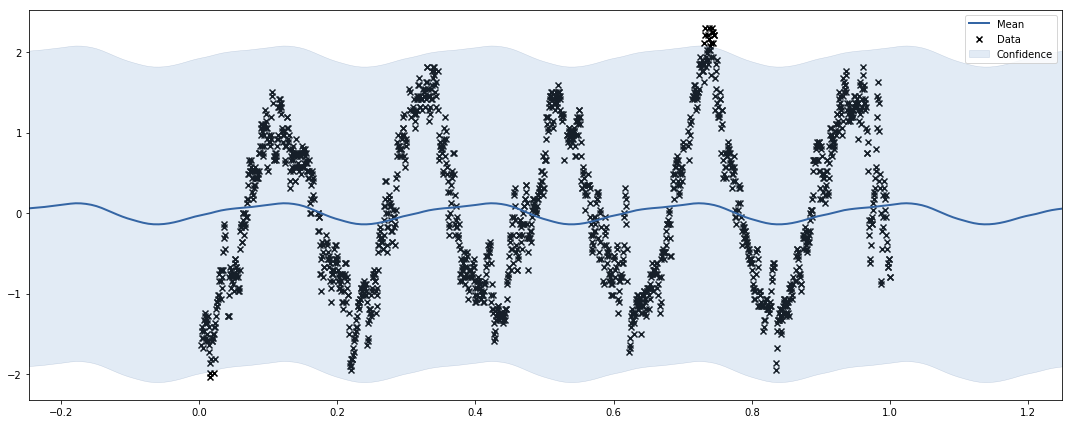

In [26]:
fig1 = DO_model.plot()
GPy.plotting.show(fig1, filename='DO')

In [27]:
DO_model.optimize_restarts(num_restarts=3)

Optimization restart 1/3, f = 450.247547497
Optimization restart 2/3, f = 448.317877608
Optimization restart 3/3, f = 559.256289192


GP_regression.,value,constraints,priors
periodic_exponential.variance,18.4806648375,+ve,
periodic_exponential.lengthscale,0.0474594918672,+ve,
periodic_exponential.period,0.820879382699,+ve,
Gaussian_noise.variance,0.0931445863634,+ve,


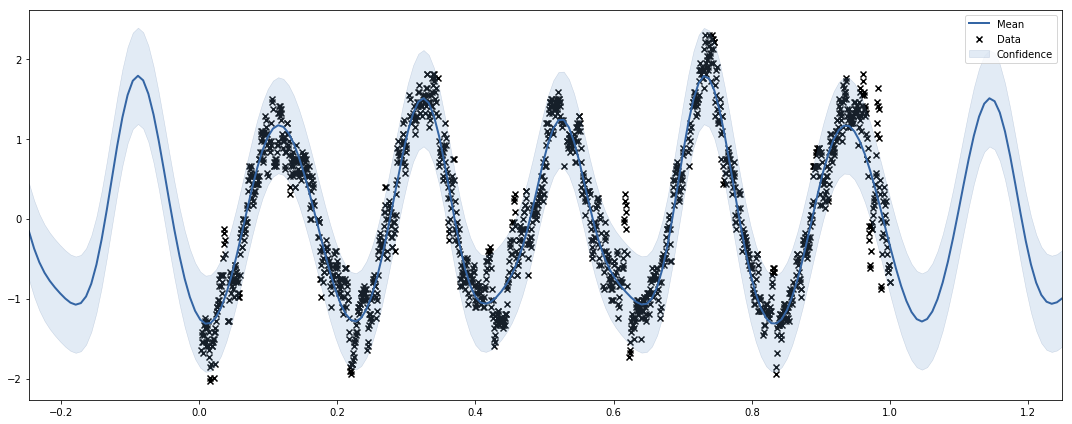

In [28]:
display(DO_model)
fig2 = DO_model.plot()
GPy.plotting.show(fig2, filename='DO_fitted')

(563, 1)
(563, 1)
(563, 1)


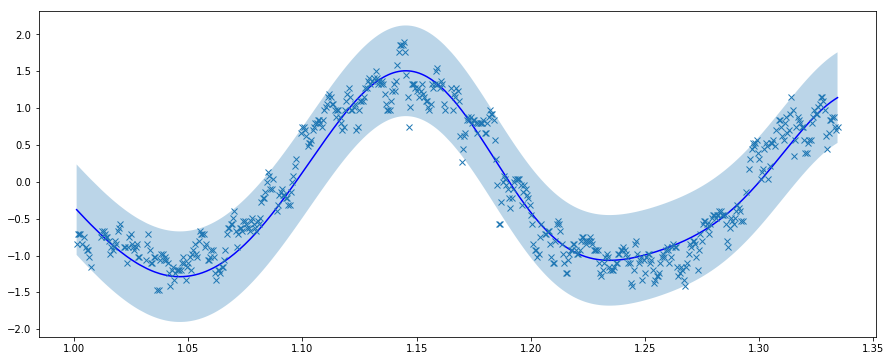

In [60]:
DO_mu, DO_var = DO_model.predict(test_days)
plot_mean_std(test_days, DO_mu, np.sqrt(DO_var), test_target)

## pH

In [40]:
periodic_kernel2 = GPy.kern.PeriodicExponential(input_dim=1, period=0.3)
pH_model = GPy.models.GPRegression(train_days, train_input[:, 0][..., np.newaxis], periodic_kernel2)

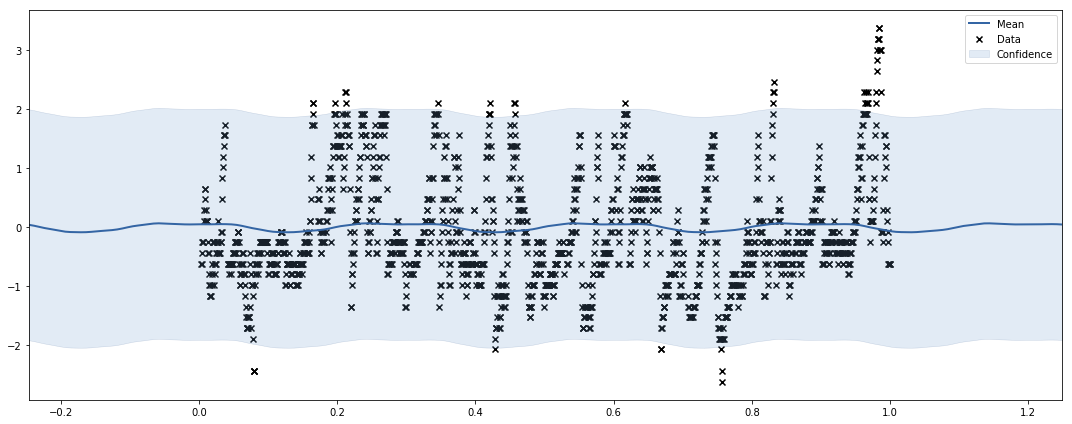

In [41]:
fig3 = pH_model.plot()
GPy.plotting.show(fig3, filename='pH')

In [42]:
pH_model.optimize_restarts(num_restarts=5)

Optimization restart 1/5, f = 2054.56013482
Optimization restart 2/5, f = 1947.56249451
Optimization restart 3/5, f = 2022.96391315
Optimization restart 4/5, f = 2054.56015717
Optimization restart 5/5, f = 2054.5601186


GP_regression.,value,constraints,priors
periodic_exponential.variance,10.6922709426,+ve,
periodic_exponential.lengthscale,0.0126529286097,+ve,
periodic_exponential.period,0.785739524702,+ve,
Gaussian_noise.variance,0.583673661263,+ve,


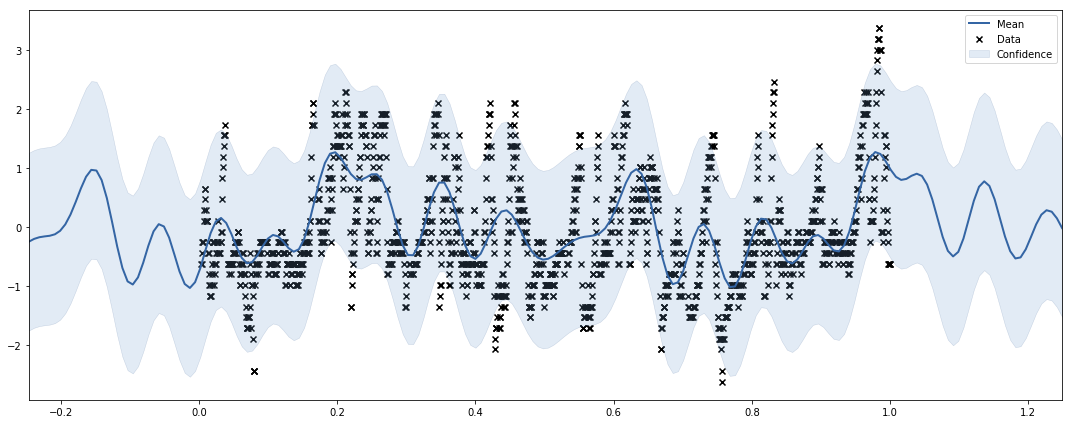

In [43]:
display(pH_model)
fig4 = pH_model.plot()
GPy.plotting.show(fig4, filename='pH_fitted')

(563, 1)
(563, 1)
(563, 1)


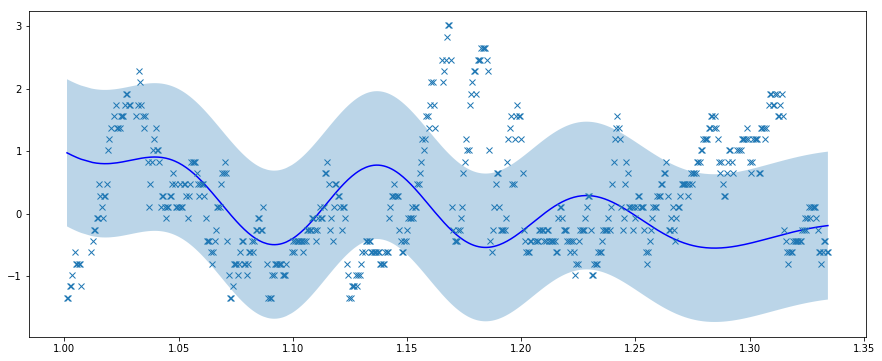

In [65]:
pH_mu, pH_var = pH_model.predict(test_days)
plot_mean_std(test_days, pH_mu, pH_var, test_input[:, 0])

## Temperature

In [49]:
periodic_kernel3 = GPy.kern.PeriodicExponential(input_dim=1, period=0.3)
Temp_model = GPy.models.GPRegression(train_days, train_input[:, 1][..., np.newaxis], periodic_kernel3)

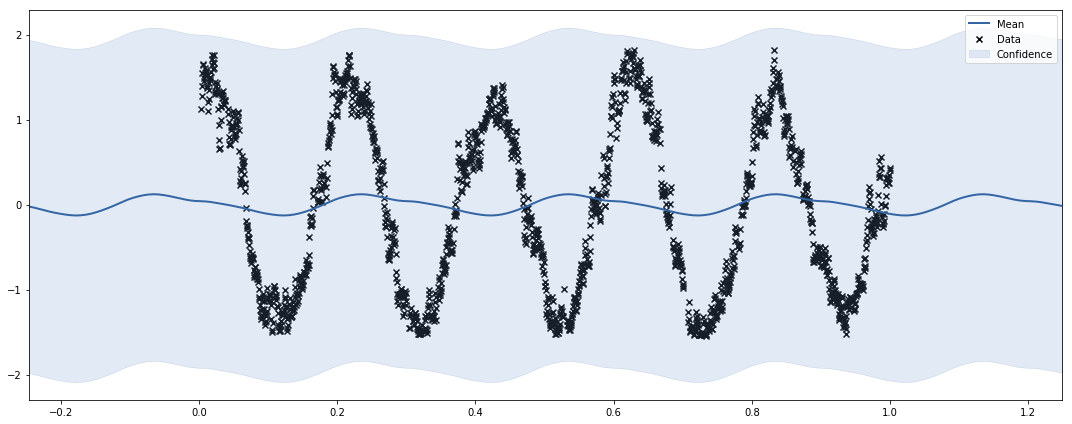

In [50]:
fig5 = Temp_model.plot()
GPy.plotting.show(fig5, filename='Temp')

In [51]:
Temp_model.optimize_restarts(num_restarts=5)

Optimization restart 1/5, f = 747.116973514
Optimization restart 2/5, f = -130.465650153
Optimization restart 3/5, f = -333.457921842
Optimization restart 4/5, f = -286.922768805
Optimization restart 5/5, f = -286.922768784


GP_regression.,value,constraints,priors
periodic_exponential.variance,19.2364211292,+ve,
periodic_exponential.lengthscale,0.0197976647724,+ve,
periodic_exponential.period,1.13520025736,+ve,
Gaussian_noise.variance,0.0358275394171,+ve,


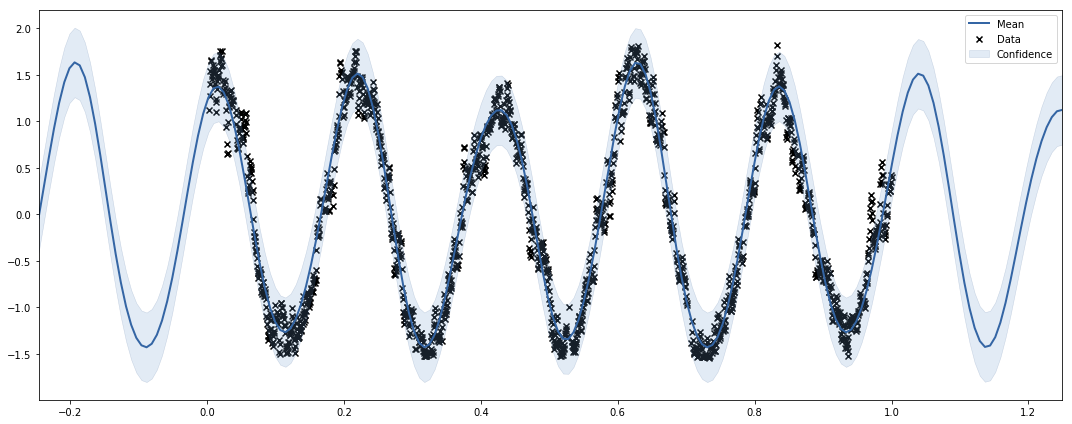

In [70]:
#founded = 1.13520025736
display(Temp_model)
Temp_model.periodic_exponential.period = 0.820879382699
#Temp_model.periodic_exponential.period = 1.13520025736
fig6 = Temp_model.plot()
GPy.plotting.show(fig6, filename='Temp_fitted')

(563, 1)
(563, 1)
(563, 1)


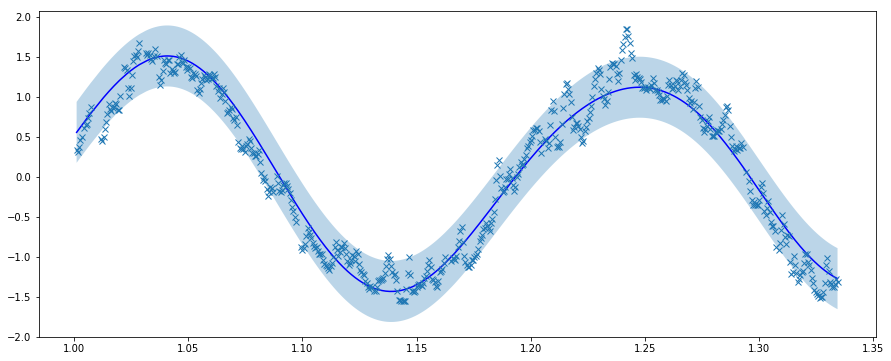

In [72]:
Temp_mu, Temp_var = Temp_model.predict(test_days)
plot_mean_std(test_days, Temp_mu, np.sqrt(Temp_var), test_input[:, 1])

## River Discharge

In [73]:
periodic_kernel4 = GPy.kern.PeriodicExponential(input_dim=1, period=0.3)
RD_model = GPy.models.GPRegression(train_days, train_input[:, 2][..., np.newaxis], periodic_kernel4)

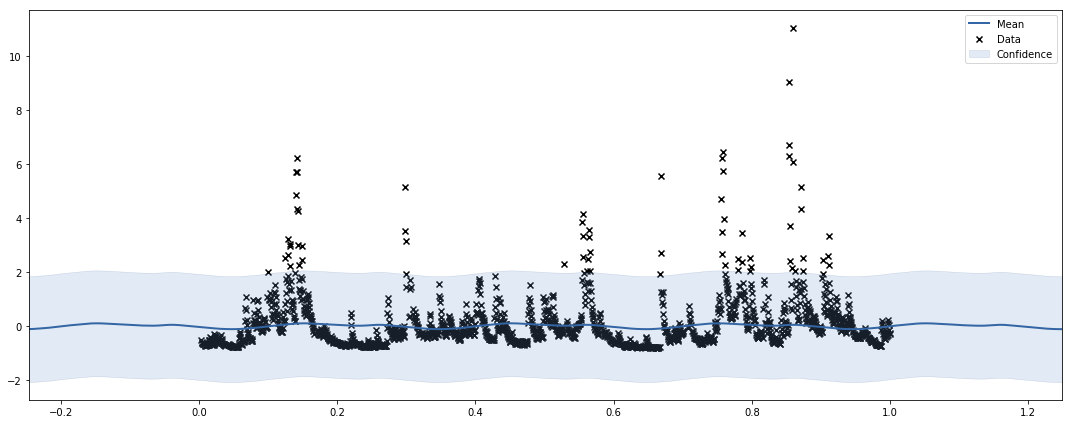

In [74]:
fig7 = RD_model.plot()
GPy.plotting.show(fig7, filename='Temp')

In [76]:
RD_model.optimize_restarts(num_restarts=5)

Optimization restart 1/5, f = 2255.74576275
Optimization restart 2/5, f = 2160.51437125
Optimization restart 3/5, f = 2160.5138826
Optimization restart 4/5, f = 2090.58457104
Optimization restart 5/5, f = 2262.63480831


GP_regression.,value,constraints,priors
periodic_exponential.variance,6.58984162137,+ve,
periodic_exponential.lengthscale,0.0238005156243,+ve,
periodic_exponential.period,1.05099286013,+ve,
Gaussian_noise.variance,0.695143446575,+ve,


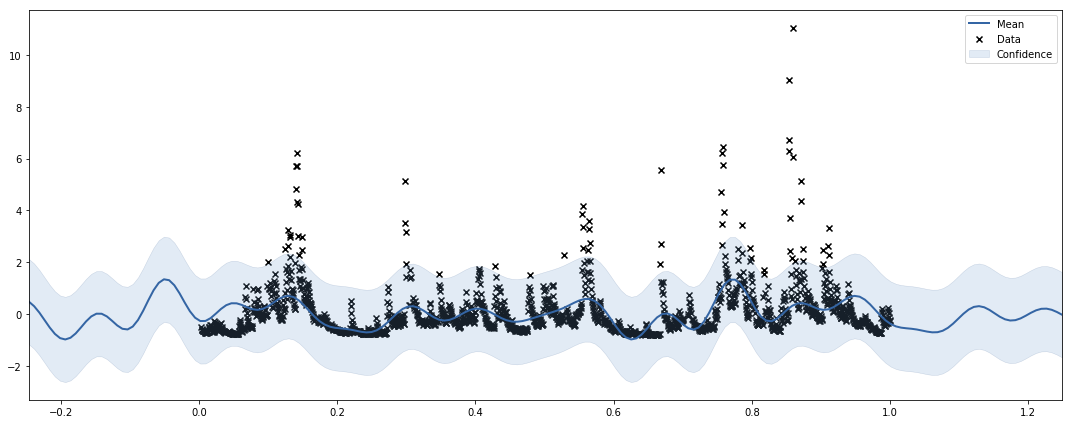

In [80]:
display(RD_model)
RD_model.periodic_exponential.period = 0.820879382699
#RD_model.periodic_exponential.period = 1.05099286013
fig8 = RD_model.plot()
GPy.plotting.show(fig8, filename='RD_fitted')

(563, 1)
(563, 1)
(563, 1)


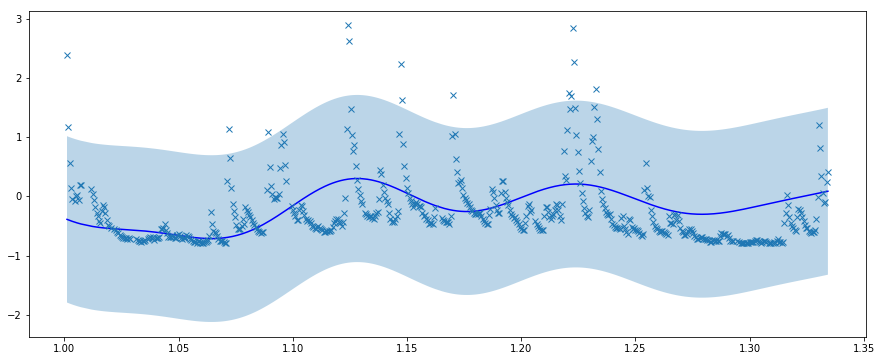

In [82]:
RD_mu, RD_var = RD_model.predict(test_days)
plot_mean_std(test_days, RD_mu, RD_var, test_input[:, 2])

## Save file

In [92]:
results = {}
results["DO"] = [DO_mu, DO_var]
results["pH"] = [pH_mu, pH_var]
results["Temp"] = [Temp_mu, Temp_var]
results["RD"] = [RD_mu, RD_var]

import pickle

with open('results.pkl', 'w') as f:
    pickle.dump(results, f)
    f.close()

# SVM Prediction

In [116]:
results = np.load("results.pkl")
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
train_input, train_target, train_days = database.next_batch(batch_size="all")
test_input, test_target, test_days = database.next_batch(set="test")

In [117]:
clf = SVR(C=16, gamma=0.5)
clf.fit(train_input, train_target)
predicted_target = clf.predict(train_input)
R = np.corrcoef(x=train_target, y=predicted_target)
# Denormalize Data
DO_mean, DO_std = database.data_transformation["Dissolved_Oxygen"]
#predicted_target = predicted_target*DO_std + DO_mean
#train_target = train_target*DO_std + DO_mean
RMSE = np.sqrt(mean_squared_error(y_pred=predicted_target, y_true=train_target))
print("Training Results")
print("Correlation Coefficient: "+str(R[0, 1]))
print("Root Mean Square Error: "+str(RMSE))

Training Results
Correlation Coefficient: 0.983912704352
Root Mean Square Error: 0.173103107682


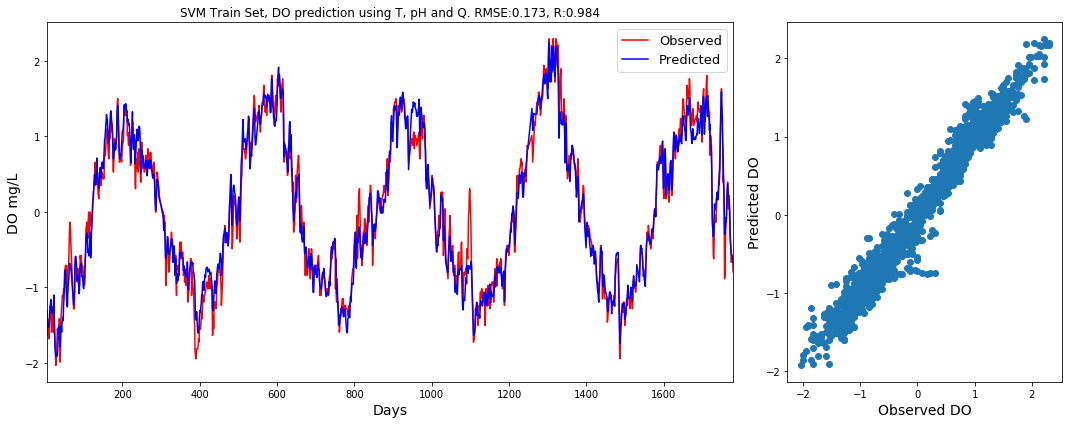

In [118]:
# Plot Train results
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])
ax0 = plt.subplot(gs[0])
ax0.plot(train_days, train_target, 'r', label="Observed")
ax0.plot(train_days, predicted_target, 'b', label="Predicted")
ax0.set_ylabel("DO mg/L", fontsize=14)
ax0.set_xlabel("Days", fontsize=14)
ax0.legend(fontsize=13)
ax0.set_xlim([np.amin(train_days), np.amax(train_days)])
plt.title("SVM Train Set, DO prediction using T, pH and Q. RMSE:"+"{0:.3f}".format(RMSE)+", R:"+"{0:.3f}".format(R[0, 1]))
ax1 = plt.subplot(gs[1])
ax1.scatter(train_target, predicted_target)
#ax1.text(0, 0, "R: "+str(R[0, 1]), fontsize=14)
ax1.set_xlabel("Observed DO", fontsize=14)
ax1.set_ylabel("Predicted DO", fontsize=14)
plt.tight_layout()
plt.savefig("svm_train_results.png")
plt.show()

In [119]:
predicted_target = clf.predict(test_input)
R = np.corrcoef(x=test_target, y=predicted_target)
# Denormalize Data
DO_mean, DO_std = database.data_transformation["Dissolved_Oxygen"]
#predicted_target = predicted_target*DO_std + DO_mean
#test_target = test_target*DO_std + DO_mean
RMSE = np.sqrt(mean_squared_error(y_pred=predicted_target, y_true=test_target))
print("Testing Results")
print("Correlation Coefficient: "+str(R[0, 1]))
print("Root Mean Square Error: "+str(RMSE))

Testing Results
Correlation Coefficient: 0.975884589673
Root Mean Square Error: 0.247191485194


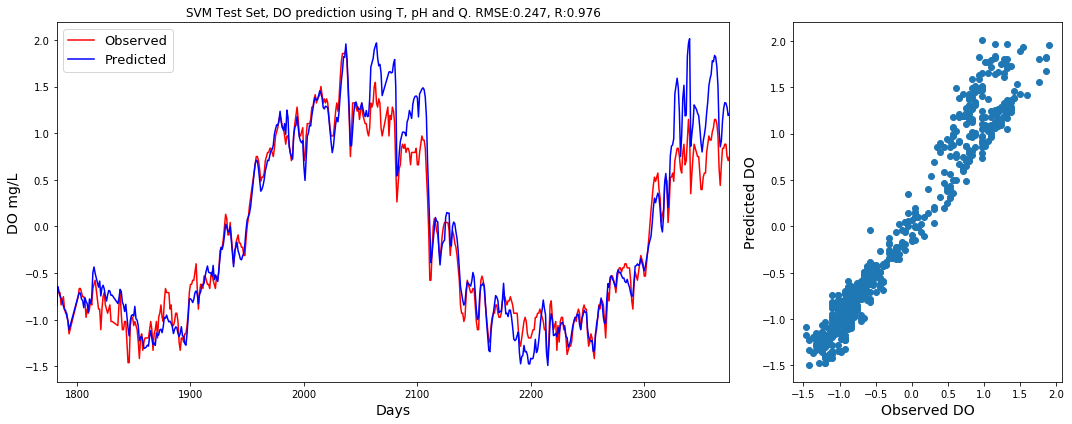

In [120]:
# Plot Test results
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])
ax0 = plt.subplot(gs[0])
ax0.plot(test_days, test_target, 'r', label="Observed")
ax0.plot(test_days, predicted_target, 'b', label="Predicted")
ax0.set_ylabel("DO mg/L", fontsize=14)
ax0.set_xlabel("Days", fontsize=14)
ax0.set_xlim([np.amin(test_days), np.amax(test_days)])
ax0.legend(fontsize=13)
plt.title("SVM Test Set, DO prediction using T, pH and Q. RMSE:"+"{0:.3f}".format(RMSE)+", R:"+"{0:.3f}".format(R[0, 1]))
ax1 = plt.subplot(gs[1])
ax1.scatter(test_target, predicted_target)
#ax1.text(0, 0, "R: "+str(R[0, 1]), fontsize=14)
ax1.set_xlabel("Observed DO", fontsize=14)
ax1.set_ylabel("Predicted DO", fontsize=14)
plt.tight_layout()
plt.savefig("svm_test_results.png")
plt.show()

In [128]:
#Gaussian process
predicted_target_gaussian = results["DO"][0][:,0]
R = np.corrcoef(x=test_target, y=predicted_target_gaussian)
# Denormalize Data
DO_mean, DO_std = database.data_transformation["Dissolved_Oxygen"]
#predicted_target = predicted_target*DO_std + DO_mean
#test_target = test_target*DO_std + DO_mean
RMSE = np.sqrt(mean_squared_error(y_pred=predicted_target_gaussian, y_true=test_target))
print("Testing Results")
print("Correlation Coefficient: "+str(R[0, 1]))
print("Root Mean Square Error: "+str(RMSE))

Testing Results
Correlation Coefficient: 0.956647119089
Root Mean Square Error: 0.268186006157


In [129]:
# SVM + Gaussian process of features
gaussian_features = np.concatenate([results["pH"][0], results["Temp"][0], results["RD"][0]], axis=1)
print(gaussian_features.shape)
predicted_target_gf = clf.predict(gaussian_features)
R = np.corrcoef(x=test_target, y=predicted_target_gf)
# Denormalize Data
DO_mean, DO_std = database.data_transformation["Dissolved_Oxygen"]
#predicted_target = predicted_target*DO_std + DO_mean
#test_target = test_target*DO_std + DO_mean
RMSE = np.sqrt(mean_squared_error(y_pred=predicted_target_gf, y_true=test_target))
print("Testing Results")
print("Correlation Coefficient: "+str(R[0, 1]))
print("Root Mean Square Error: "+str(RMSE))

(563, 3)
Testing Results
Correlation Coefficient: 0.948311128198
Root Mean Square Error: 0.295154479716


In [137]:
# SVM + gaussian DO
predicted = predicted_target_gf*(1/(0.1731**2)) + np.multiply(predicted_target_gaussian, 1/(results["DO"][0][:,0]**2))
norm_array = 1/(0.1731**2) + 1/(results["DO"][0][:, 0]**2)
predicted = np.multiply(predicted, 1/norm_array)
R = np.corrcoef(x=test_target, y=predicted)
# Denormalize Data
DO_mean, DO_std = database.data_transformation["Dissolved_Oxygen"]
#predicted_target = predicted_target*DO_std + DO_mean
#test_target = test_target*DO_std + DO_mean
RMSE = np.sqrt(mean_squared_error(y_pred=predicted, y_true=test_target))
print("Testing Results")
print("Correlation Coefficient: "+str(R[0, 1]))
print("Root Mean Square Error: "+str(RMSE))

Testing Results
Correlation Coefficient: 0.953696177627
Root Mean Square Error: 0.277280257208
